In [212]:
import pandas as pd
import numpy as np
import scipy
import itertools
from collections import Counter
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\creed\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [9]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [10]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [155]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [157]:
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

## Параметрические критерии. Тест

В одном из выпусков программы "Разрушители легенд" проверялось, действительно ли заразительна зевота. В эксперименте участвовало 50 испытуемых, проходивших собеседование на программу. Каждый из них разговаривал с рекрутером; в конце 34 из 50 бесед рекрутер зевал. Затем испытуемых просили подождать решения рекрутера в соседней пустой комнате.

Во время ожидания 10 из 34 испытуемых экспериментальной группы и 4 из 16 испытуемых контрольной начали зевать. Таким образом, разница в доле зевающих людей в этих двух группах составила примерно 4.4%. Ведущие заключили, что миф о заразительности зевоты подтверждён.

Можно ли утверждать, что доли зевающих в контрольной и экспериментальной группах отличаются статистически значимо? Посчитайте достигаемый уровень значимости при альтернативе заразительности зевоты, округлите до четырёх знаков после десятичной точки.

In [22]:
print('p_t=%f\np_c=%f' % (10/34, 4/16))

p_t=0.294118
p_c=0.250000


In [6]:
a = [0]*24 + [1]*10
b = [0]*12 + [1]*4
print(a, b)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


In [14]:
proportion_confint(10,34,method='wilson'), proportion_confint(4,16,method='wilson')

((0.16834630670422424, 0.4616890979471444),
 (0.10182067491213043, 0.4949831653550878))

In [7]:
proportions_confint_diff_ind(a, b)

(-0.2175577216559601, 0.3057930157736072)

In [28]:
z = proportions_diff_z_stat_ind(a,b)
print('p-value: %.4f' % proportions_diff_z_test(z, 'greater'))

p-value: 0.3729


Ежегодно более 200000 людей по всему миру сдают стандартизированный экзамен GMAT при поступлении на программы MBA. Средний результат составляет 525 баллов, стандартное отклонение — 100 баллов.

Сто студентов закончили специальные подготовительные курсы и сдали экзамен. Средний полученный ими балл — 541.4. Проверьте гипотезу о неэффективности программы против односторонней альтернативы о том, что программа работает. Отвергается ли на уровне значимости 0.05 нулевая гипотеза? Введите достигаемый уровень значимости, округлённый до 4 знаков после десятичной точки.

In [39]:
_zconfint_generic(541.4, 100/sqrt(100), 0.05, 'two-sided')

(521.8003601545994, 560.9996398454006)

In [46]:
z = ((541.5 - 525) * 10) / 100
1-stats.norm.cdf(z)

0.0494714680336481

## Непараметрические критерии. Тест

Давайте вернёмся к данным выживаемости пациентов с лейкоцитарной лимфомой из видео про критерий знаков:

49, 58, 75, 110, 112, 132, 151, 276, 281, 362
 

Измерено остаточное время жизни с момента начала наблюдения (в неделях); звёздочка обозначает цензурирование сверху — исследование длилось 7 лет, и остаточное время жизни одного пациента, который дожил до конца наблюдения, неизвестно.

Поскольку цензурировано только одно наблюдение, для проверки гипотезы H_0\colon med X = 200H 
0
​	 :medX=200 на этих данных можно использовать критерий знаковых рангов — можно считать, что время дожития последнего пациента в точности равно 362, на ранг этого наблюдения это никак не повлияет.

Критерием знаковых рангов проверьте эту гипотезу против двусторонней альтернативы, введите достигаемый уровень значимости, округлённый до четырёх знаков после десятичной точки.

In [8]:
m0 = 200
x = [49, 58, 75, 110, 112, 132, 151, 276, 281, 362]
stats.wilcoxon(np.array(x)-m0)

WilcoxonResult(statistic=17.0, pvalue=0.2845026979112075)

В ходе исследования влияния лесозаготовки на биоразнообразие лесов острова Борнео собраны данные о количестве видов деревьев в 12 лесах, где вырубка не ведётся:

22, 22, 15, 13, 19, 19, 18, 20, 21, 13, 13, 15

и в 9 лесах, где идёт вырубка:

17, 18, 18, 15, 12, 4, 14, 15, 10.

Проверьте гипотезу о равенстве среднего количества видов в двух типах лесов против односторонней альтернативы о снижении биоразнообразия в вырубаемых лесах. Используйте ранговый критерий. Чему равен достигаемый уровень значимости? Округлите до четырёх знаков после десятичной точки.

In [69]:
x1 = [22, 22, 15, 13, 19, 19, 18, 20, 21, 13, 13, 15]
x2 = [17, 18, 18, 15, 12, 4, 14, 15, 10]

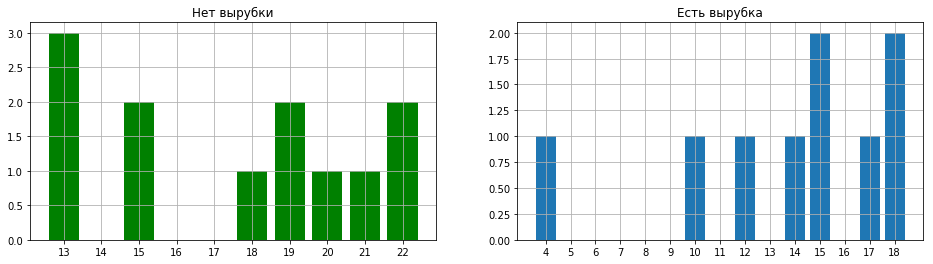

In [64]:
pylab.figure(figsize=(16,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.bar(Counter(x1).keys(), Counter(x1).values(), color='green')
pylab.xticks(range(min(x1), max(x1)+1))
pylab.title('Нет вырубки')

pylab.subplot(1,2,2)
pylab.grid()
pylab.bar(Counter(x2).keys(), Counter(x2).values())
pylab.xticks(range(min(x2), max(x2)+1))
pylab.title('Есть вырубка')

pylab.show()

In [70]:
np.mean(x1), np.mean(x2)

(17.5, 13.666666666666666)

In [86]:
stats.mannwhitneyu(x1, x2, alternative='greater')

MannwhitneyuResult(statistic=81.0, pvalue=0.02900499272087373)

28 января 1986 года космический шаттл "Челленджер" взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для 23 предшествовавших катастрофе полётов "Челленджера" известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.

С помощью бутстрепа постройте 95% доверительный интервал для разности средних температур воздуха при запусках, когда уплотнительные кольца повреждались, и запусках, когда повреждений не было. Чему равна его ближайшая к нулю граница? Округлите до четырёх знаков после запятой.

In [143]:
data = pd.read_csv('static/challenger.txt', sep='\t', index_col=0)
data.shape

(23, 2)

In [144]:
data.head()

,Temperature,Incident
Apr12.81,18.9,0
Nov12.81,21.1,1
Mar22.82,20.6,0
Nov11.82,20.0,0
Apr04.83,19.4,0


In [154]:
x1 = data[data.Incident == 0].Temperature.values
x2 = data[data.Incident != 0].Temperature.values

In [159]:
np.mean(x1), np.mean(x2)

(22.28125, 17.614285714285717)

In [200]:
np.random.seed(0)

x1_scores = [*map(np.mean, get_bootstrap_samples(x1, 1000))]
x2_scores = [*map(np.mean, get_bootstrap_samples(x2, 1000))]

print ("95% confidence interval for the x1:",  stat_intervals(x1, 0.05))
print ("95% confidence interval for the x2:",  stat_intervals(x2, 0.05))

95% confidence interval for the x1: [19.0875 26.7875]
95% confidence interval for the x2: [12.03 23.48]


In [202]:
delta_mean_scores = [*map(lambda x: x[1] - x[0], zip(x1, x2))]

In [203]:
print ("95% confidence interval for the difference between means",  stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for the difference between means [-9.93   2.125]


На данных предыдущей задачи проверьте гипотезу об одинаковой средней температуре воздуха в дни, когда уплотнительный кольца повреждались, и дни, когда повреждений не было. Используйте перестановочный критерий и двустороннюю альтернативу. Чему равен достигаемый уровень значимости? Округлите до четырёх знаков после десятичной точки.

In [204]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [205]:
def get_random_combinations(n1, n2, max_combinations):
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [206]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [210]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [238]:
np.random.seed(0)
permutation_test(x2,x1, 10000)

0.0057